# Prepare Dataset: Compute Stats and Normalize
> Compute dataset statistics, normalize and clean raw datasets and save them as new `.npy` pickle files

\[__EDIT EXPLANATIONS BELOW__ to change sg-temp --> energy data\]

**For lab 1 dataset** (raw dataset is in `./sg_temps`)
1. Compute dataset stats and write it to __`sg_temps_stats.csv`__.
    - Read/import it as `pd.read_csv('./sg_temps_stats.csv',header=0,index_col=0)`
1. Normalize raw dataset with given mean/median and scale.
    - For lab 1, use `mean=28`, and scale it with `2xS.D. = 1.6`.
1. Save normalized datasets as `./train_norm.npy` and `./test_norm.npy`
    - You can later load them with numpy, e.g.
    ```python
    with open('train_norm.npy', 'rb') as f:
        train_norm = np.load(f)
    ```

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

# read the data
df = pd.read_csv('data/PJM_Load_hourly.csv')

# shape and data types of the data
print(df.shape)
print(df.dtypes)

(32896, 2)
Datetime        object
PJM_Load_MW    float64
dtype: object


# Handling Missing data

In [ ]:
# sort by date & time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

# renaming the target variable columns
df.rename(columns={'PJM_Load_MW':'demand_in_MW'}, inplace=True)

# display the first couple of rows
df.head()

,Datetime,demand_in_MW
0,1998-04-01 01:00:00,22259.0
1,1998-04-01 02:00:00,21244.0
2,1998-04-01 03:00:00,20651.0
3,1998-04-01 04:00:00,20421.0
4,1998-04-01 05:00:00,20713.0


In [ ]:
# let's see if we have a continuous dataset
df = df.set_index('Datetime')
print(f'df.index.freq is set to: {df.index.freq}')

df.index.freq is set to: None


In [ ]:
date_range = pd.date_range(df.index[0],df.index[-1],freq='H')
print(f'The difference in length between the custom date range and our dataset is {(len(date_range)-len(df))}:')
print(date_range.difference(df.index))

The difference in length between the custom date range and our dataset is 8:
DatetimeIndex(['1998-04-05 03:00:00', '1998-10-25 02:00:00',
               '1999-04-04 03:00:00', '1999-10-31 02:00:00',
               '2000-04-02 03:00:00', '2000-10-29 02:00:00',
               '2001-04-01 03:00:00', '2001-10-28 02:00:00'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
df.head()

,demand_in_MW
Datetime,
1998-04-01 01:00:00,22259.0
1998-04-01 02:00:00,21244.0
1998-04-01 03:00:00,20651.0
1998-04-01 04:00:00,20421.0
1998-04-01 05:00:00,20713.0


In [ ]:
# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['demand_in_MW'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


## Dataset stats
- to be used later to normalize the data

In [ ]:
len(df)

NameError: name 'df' is not defined

In [ ]:
#find mean
print(df.mean())

#find std
print(df.std())


demand_in_MW    29764.228635
dtype: float64
demand_in_MW    5850.797163
dtype: float64


### Import data

In [ ]:
train_raw = pd.read_csv('./data/train.csv',header=None)[0].values
test_raw = pd.read_csv('./data/test.csv',header=None)[0].values

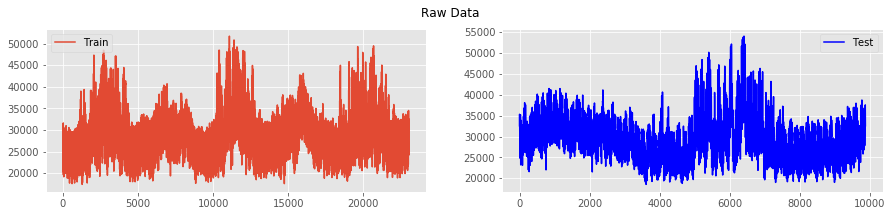

In [ ]:
_,axs = plt.subplots(ncols=2,nrows=1,figsize=[15,3])
axs[0].plot(train_raw,label='Train')
axs[1].plot(test_raw,color='b',label='Test')
for k in range(axs.shape[0]):
    axs[k].legend()
plt.suptitle('Raw Data');

### Stat-s for datasets:
- compute stat-s and write them to `./data_stats.csv`

In [ ]:
data_stats = {}
data_stats['Train'] = [train_raw.min(), train_raw.max(),
                       train_raw.mean(), np.median(train_raw),
                       train_raw.std(), train_raw.max() - train_raw.min()]
data_stats['Test'] = [test_raw.min(), test_raw.max(),
                       test_raw.mean(), np.median(test_raw),
                       test_raw.std(), test_raw.max() - test_raw.min()]
indx = ['min','max','mean','median','std','range']

# write to file
data_stats_df  = pd.DataFrame(data=data_stats,index=indx)
data_stats_df.to_csv('./data_stats.csv',
                     header=True,index=True)

print('Dataset statistics:')
data_stats_df

Dataset statistics:


,Train,Test
min,17461.000000,18549.000000
max,51714.000000,54030.000000
mean,29452.555835,30491.271806
median,29361.000000,30398.000000
std,5874.732837,5728.995451
range,34253.000000,35481.000000


### Histograms:

In [ ]:
# Number of bins:
N_bins = 50
# histogram range:
x_range = [min(data_stats_df.loc['min']),max(data_stats_df.loc['max'])]
hist_bins = np.linspace(x_range[0],x_range[1],N_bins)

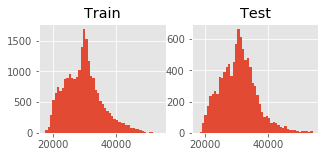

In [ ]:
_, axs = plt.subplots(nrows=1,ncols=2,figsize=[5,2],sharex=True,squeeze=True)
# Train
axs[0].hist(train_raw, bins=hist_bins)
axs[0].set_title('Train')

# Test
axs[1].hist(test_raw, bins=hist_bins)
axs[1].set_title('Test')

plt.show()

## Normalize

Generally, we would use the stat-s computed above for the training data to normalize our data. But for consistency we will use the same procedure as in the **lab 1** (With approx. `mean`:29766.43, `2x s.d.`:11699.54).
$$x_{normalized} = \frac{x_{raw}-29766.43}{11699.54}$$

__How did you derive 11699.54?__

### Normalize and Write Updated Datasets to New Files
- Normalize

In [ ]:
x_mean = 29766.43
x_scale = 11699.54
train_norm = (train_raw - x_mean)/x_scale
test_norm = (test_raw - x_mean)/x_scale

- Write arrays to `./train_norm.npy` and `./test_norm.npy`

In [ ]:
# normalized training dataset:
with open('train_norm.npy', 'wb') as f:
    np.save(f, train_norm)

# normalized test dataset:
with open('test_norm.npy', 'wb') as f:
    np.save(f, test_norm)
    
# # For loading them back use:
# # with open('train_norm.npy', 'rb') as f:
# #    x_test = np.load(f)

---
Plot normalized data:

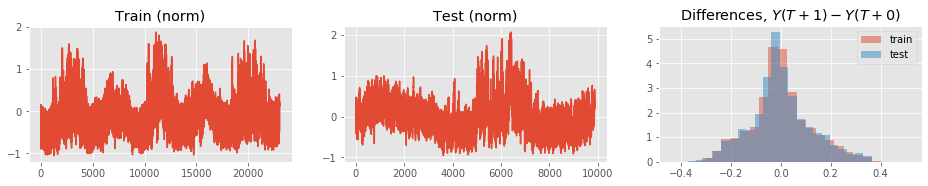

In [ ]:
_,axs = plt.subplots(ncols=3,nrows=1,figsize=[16,2.5],squeeze=True)
# Plot time series
axs[0].plot(train_norm)
axs[0].set_title('Train (norm)')
axs[1].plot(test_norm)
axs[1].set_title('Test (norm)')
# deltaY: differences Y(t+1)-Y(t)
axs[2].hist((train_norm[1:]-train_norm[:-1]),bins=25,density=True,alpha=.5,label='train')
axs[2].hist(test_norm[1:]-test_norm[:-1],bins=25,density=True,alpha=.5,label='test')
plt.title('Differences, $Y(T+1)-Y(T+0)$')
plt.legend()
plt.show()

---

- What do we know about the dataset, e.g. how is it generated? any regularities?

---

### Persistence Loss (for Normalized Data with MSE loss)

- note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
---
Compute persistence loss and save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
- You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.
- Here, `persistence` is computed starting from the first elements of `train_norm` (or `test_norm`). Your exact training/testing dataset will start from the last element in the window, which will be set as first $Y(T+0)$.

In [ ]:
import utils

In [ ]:
Tlead = 5
# utils.persistence_loss by default uses MSE as metric
persistence_data = np.array({'lead_time':Tlead,
                             'persist_train':utils.persistence_loss(train_norm,lead_time=Tlead),
                             'persist_test':utils.persistence_loss(test_norm,lead_time=Tlead)})

with open('persistence_T{}.npy'.format(Tlead), 'wb') as f:
    np.save(f,persistence_data)

print(persistence_data)

{'lead_time': 5, 'persist_train': 0.23281556767206377, 'persist_test': 0.2319281201551854}


In "autocaffe" there's an additional (and unnecessary) 0.5x factor for persistence:

In [ ]:
# persistence_data = persistence_data.item()
print('Autocaffe\'s "persistence" for T+{}\ntrain: {}\ntest{}'.format(
    Tlead,persistence_data.item()['persist_train']/2,persistence_data.item()['persist_test']/2) )

Autocaffe's "persistence" for T+5
train: 0.11640778383603188
test0.1159640600775927
